In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pickle
import seg_metrics.seg_metrics as sg
import json
import SimpleITK as sitk
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from os.path import expanduser

#### compare the prediction from nnU-Net with the PET ground truth

In [2]:
DATASET_ID = 160
TEST_ID = 0
MODEL_CONFIG_SUFFIX = '' # '' or '/2d' i.e. none means 3d_fullres

In [3]:
RAW_DIR = '/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_raw'
DATASET_BASE_DIR = '{}/Dataset{}_RNSH_HFlung'.format(RAW_DIR, DATASET_ID)

In [4]:
# get the patient ID for this hold-out test patient
MAPPING_FILE = '{}/patient-mapping-Dataset{}_RNSH_HFlung.json'.format(RAW_DIR, DATASET_ID)

with open(MAPPING_FILE, 'r') as fp:
    patient_map_d = json.load(fp)

In [5]:
patient_id = int(patient_map_d['test'][TEST_ID][0].split('/')[-1].split('.')[0].split('Patient')[1])
patient_id

4

In [6]:
CHECKPOINT = 'best'
# CHECKPOINT = 'final'

prediction_img = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/{}{}/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, CHECKPOINT, MODEL_CONFIG_SUFFIX, TEST_ID)).get_fdata().astype(int)
prediction_img.shape

(320, 320, 300)

In [7]:
np.unique(prediction_img)

array([0, 1, 2, 3])

In [8]:
label_img = nib.load('{}/labelsTs/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_BASE_DIR, TEST_ID)).get_fdata().astype(int)
label_img.shape

(320, 320, 300)

In [9]:
DISPLAY_IDX = 150

In [10]:
labels_d = {0:'background', 1:'high', 2:'medium', 3:'low'}

# set up the colour map
colours_d = {
    0: 'black',
    1: 'lime',
    2: 'lightseagreen',
    3: 'slategray'
}

cm = ListedColormap(colours_d.values())

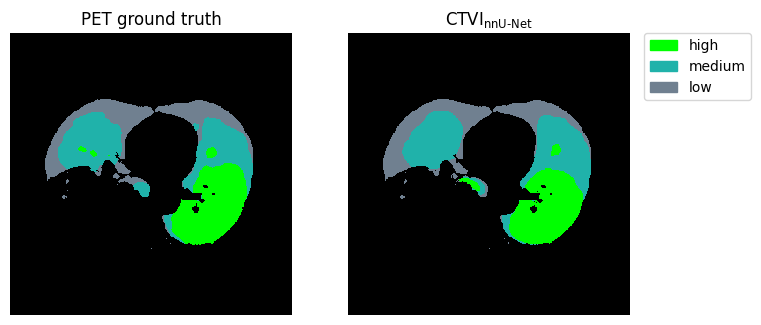

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

_ = ax1.imshow(label_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')
ax1.set_title('PET ground truth')
ax1.set_axis_off()

im = ax2.imshow(prediction_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i]) ) for i in [1,2,3] ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

if MODEL_CONFIG_SUFFIX == '':
    ax2.set_title(r'CTVI$_\text{nnU-Net}$')
else:
    ax2.set_title(r'CTVI$_\text{nnU-Net-2D}$')
ax2.set_axis_off()

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
nnunet_cm = confusion_matrix(label_img.ravel(), prediction_img.ravel(), labels=[1,2,3])
nnunet_cm = np.around(nnunet_cm.astype('float') / nnunet_cm.sum(axis=1)[:, np.newaxis], decimals=2)

In [14]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# base_color = '#4D5249'
base_color = '#20B2AA'
color_shades = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f']
cmap_colors = []

for color_shade in color_shades:
    cmap_colors.append(base_color+color_shade+color_shade)

confusion_matrix_cmap= ListedColormap(cmap_colors)

In [15]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4,4

saved figure to /home/daryl/figures/confusion-matrix-ctvi-nnunet-set-160-tid-00-P04.png


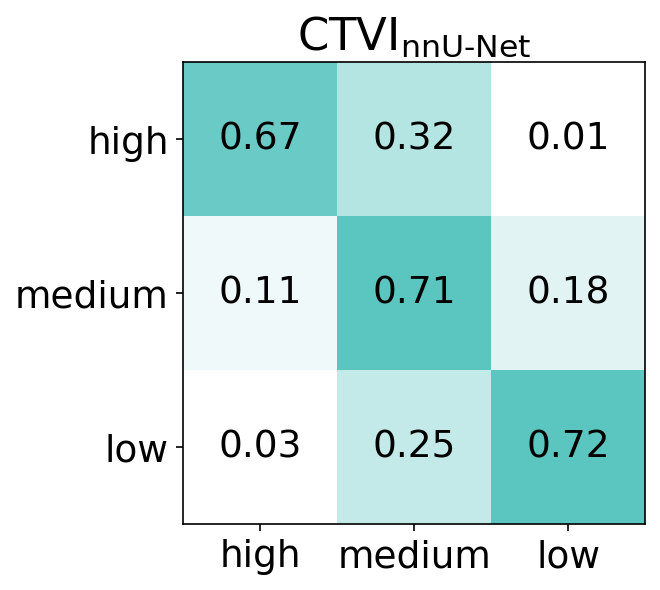

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=nnunet_cm, display_labels=['high','medium','low'])
disp.plot(values_format='.2f', cmap=confusion_matrix_cmap, 
          im_kw={'vmin':0, 'vmax':1.0}, 
          colorbar=False, 
          text_kw={'color':'black', 'fontsize':'medium', 'fontweight':'medium'})
if MODEL_CONFIG_SUFFIX == '':
    plt.title(r'CTVI$_\text{nnU-Net}$')
else:
    plt.title(r'CTVI$_\text{nnU-Net-2D}$')
plt.gca().xaxis.label.set_visible(False)
plt.gca().yaxis.label.set_visible(False)
fig_filename = '{}/figures/confusion-matrix-ctvi-nnunet{}-set-{:03d}-tid-{:02d}-P{:02d}.png'.format(expanduser('~'), MODEL_CONFIG_SUFFIX.replace('/','-'), DATASET_ID, TEST_ID, patient_id)
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

In [17]:
nnunet_dsc = {}
print('nnU-Net and PET DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(prediction_img[label_img==k]==k)*2.0 / (np.sum(prediction_img[prediction_img==k]==k) + np.sum(label_img[label_img==k]==k))
    nnunet_dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

nnU-Net and PET DSC
high: 0.72
medium: 0.66
low: 0.73


In [18]:
labels = [1, 2, 3]  # high, medium, low

nnunet_metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=prediction_img,
                  csv_file=None,
                  metrics=['msd','hd95'])

nnunet_hd95 = {}
nnunet_hd95['high'] = nnunet_metrics[0]['hd95'][0]
nnunet_hd95['medium'] = nnunet_metrics[0]['hd95'][1]
nnunet_hd95['low'] = nnunet_metrics[0]['hd95'][2]

nnunet_msd = {}
nnunet_msd['high'] = nnunet_metrics[0]['msd'][0]
nnunet_msd['medium'] = nnunet_metrics[0]['msd'][1]
nnunet_msd['low'] = nnunet_metrics[0]['msd'][2]

In [19]:
print('Mean surface distance (MSD)')
print('high: {}'.format(round(nnunet_msd['high'])))
print('medium: {}'.format(round(nnunet_msd['medium'])))
print('low: {}'.format(round(nnunet_msd['low'])))

Mean surface distance (MSD)
high: 11
medium: 4
low: 2


In [20]:
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(nnunet_hd95['high'])))
print('medium: {}'.format(round(nnunet_hd95['medium'])))
print('low: {}'.format(round(nnunet_hd95['low'])))

Hausdorff distance 95% percentile
high: 64
medium: 14
low: 9


#### compare with DIR approach

In [21]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)

In [22]:
ctvi_jac_label_arr = sitk.GetArrayFromImage(sitk.ReadImage('{}/ctvi-jac-label.mha'.format(PREPROCESSED_MHA_DIR))).astype(int)
ctvi_jac_label_arr.shape

(300, 320, 320)

In [23]:
ctvi_hu_label_arr = sitk.GetArrayFromImage(sitk.ReadImage('{}/ctvi-hu-label.mha'.format(PREPROCESSED_MHA_DIR))).astype(int)
ctvi_hu_label_arr.shape

(300, 320, 320)

In [24]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 150

saved figure to /home/daryl/figures/ctvi-nnunet-set-160-tid-00-P04.png


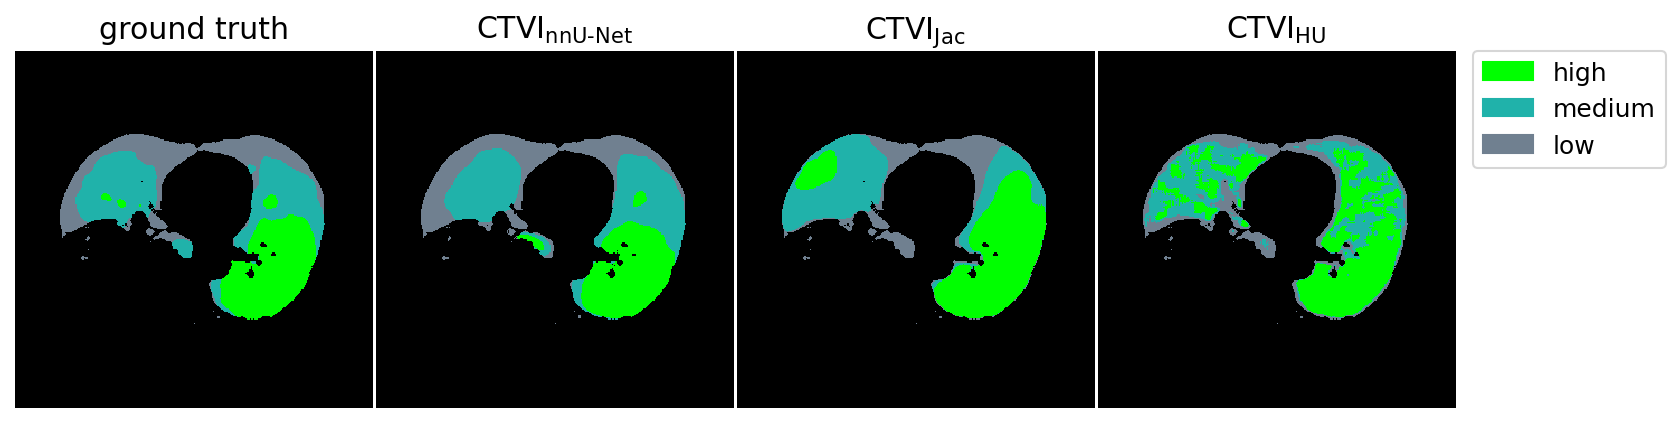

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,7))

ax1.imshow(label_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')
ax1.set_title('ground truth')
ax1.set_axis_off()

ax2.imshow(prediction_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')

if MODEL_CONFIG_SUFFIX == '':
    ax2.set_title(r'CTVI$_\text{nnU-Net}$')
else:
    ax2.set_title(r'CTVI$_\text{nnU-Net-2D}$')
ax2.set_axis_off()

ax3.imshow(ctvi_jac_label_arr[DISPLAY_IDX], cmap=cm, interpolation='none')
ax3.set_title(r'CTVI$_\text{Jac}$')
ax3.set_axis_off()

ax4.imshow(ctvi_hu_label_arr[DISPLAY_IDX], cmap=cm, interpolation='none')
ax4.set_title(r'CTVI$_\text{HU}$')
ax4.set_axis_off()

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i]) ) for i in [1,2,3] ]
_ = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

fig_filename = '{}/figures/ctvi-nnunet{}-set-{:03d}-tid-{:02d}-P{:02d}.png'.format(expanduser('~'), MODEL_CONFIG_SUFFIX.replace('/','-'), DATASET_ID, TEST_ID, patient_id)
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

#### CTVI-Jac confusion matrix

In [26]:
ctvi_jac_label_arr.shape, label_img.shape

((300, 320, 320), (320, 320, 300))

In [27]:
# transpose the CTVI image to match the groundtruth (i.e. from z,y,x to x,y,z)
ctvi_jac_label_arr = np.transpose(ctvi_jac_label_arr, axes=(2, 1, 0))

In [28]:
ctvi_jac_cm = confusion_matrix(label_img.ravel(), ctvi_jac_label_arr.ravel(), labels=[1,2,3])
ctvi_jac_cm = np.around(ctvi_jac_cm.astype('float') / ctvi_jac_cm.sum(axis=1)[:, np.newaxis], decimals=2)

In [29]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4,4

saved figure to /home/daryl/figures/confusion-matrix-ctvi-jac-set-160-tid-00-P04.png


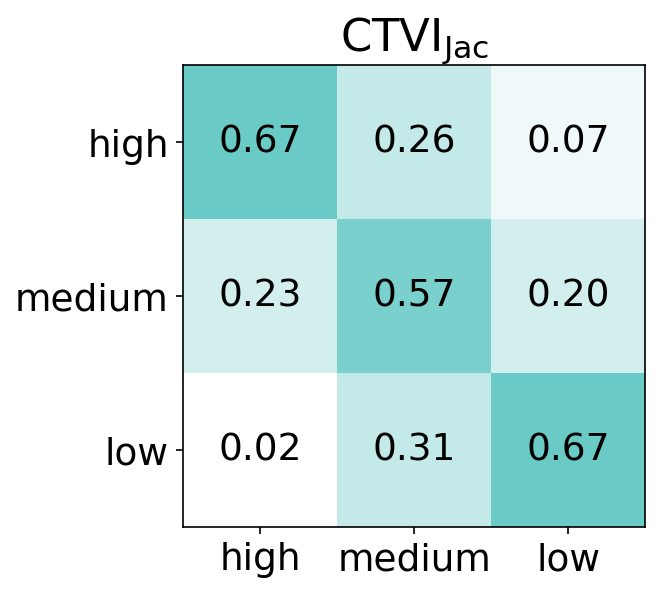

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=ctvi_jac_cm, display_labels=['high','medium','low'])
disp.plot(values_format='.2f', cmap=confusion_matrix_cmap, 
          im_kw={'vmin':0, 'vmax':1.0}, 
          colorbar=False, 
          text_kw={'color':'black', 'fontsize':'medium', 'fontweight':'medium'})
plt.title(r'CTVI$_\text{Jac}$')
plt.gca().xaxis.label.set_visible(False)
plt.gca().yaxis.label.set_visible(False)
fig_filename = '{}/figures/confusion-matrix-ctvi-jac-set-{:03d}-tid-{:02d}-P{:02d}.png'.format(expanduser('~'), DATASET_ID, TEST_ID, patient_id)
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

#### color bar for confusion matrix

saved figure to /home/daryl/figures/confusion-matrix-colorbar.png


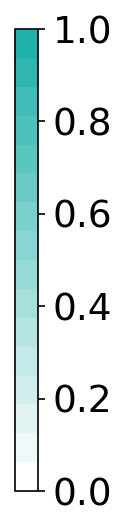

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=ctvi_jac_cm, display_labels=['high','medium','low'])
disp.plot(values_format='.2f', cmap=confusion_matrix_cmap, 
          im_kw={'vmin':0, 'vmax':1.0}, 
          colorbar=True, 
          text_kw={'color':'black', 'fontsize':'medium', 'fontweight':'medium'})
plt.title(r'CTVI$_\text{Jac}$')
plt.gca().xaxis.label.set_visible(False)
plt.gca().yaxis.label.set_visible(False)
plt.gca().set_visible(False)
fig_filename = '{}/figures/confusion-matrix-colorbar.png'.format(expanduser('~'))
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

#### CTVI-HU confusion matrix

In [32]:
ctvi_hu_label_arr.shape, label_img.shape

((300, 320, 320), (320, 320, 300))

In [33]:
# transpose the CTVI image to match the groundtruth (i.e. from z,y,x to x,y,z)
ctvi_hu_label_arr = np.transpose(ctvi_hu_label_arr, axes=(2, 1, 0))

In [34]:
ctvi_hu_cm = confusion_matrix(label_img.ravel(), ctvi_hu_label_arr.ravel(), labels=[1,2,3])
ctvi_hu_cm = np.around(ctvi_hu_cm.astype('float') / ctvi_hu_cm.sum(axis=1)[:, np.newaxis], decimals=2)

In [35]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4,4

saved figure to /home/daryl/figures/confusion-matrix-ctvi-hu-set-160-tid-00-P04.png


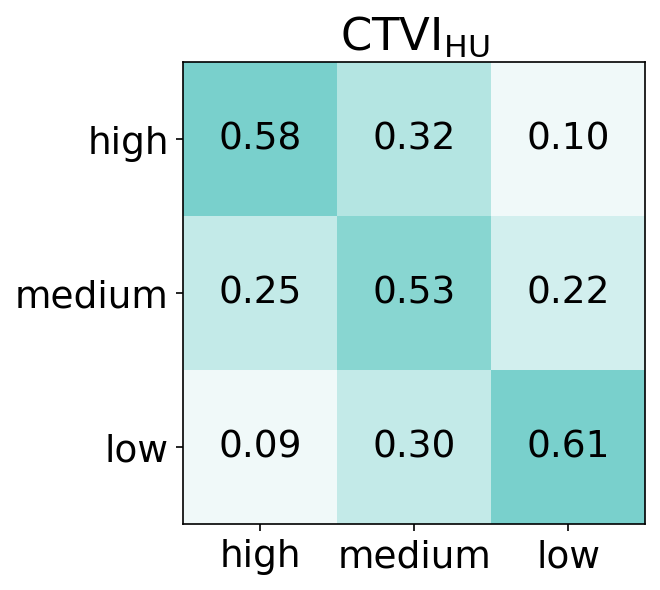

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=ctvi_hu_cm, display_labels=['high','medium','low'])
disp.plot(values_format='.2f', cmap=confusion_matrix_cmap, 
          im_kw={'vmin':0, 'vmax':1.0}, 
          colorbar=False, 
          text_kw={'color':'black', 'fontsize':'medium', 'fontweight':'medium'})
plt.title(r'CTVI$_\text{HU}$')
plt.gca().xaxis.label.set_visible(False)
plt.gca().yaxis.label.set_visible(False)
fig_filename = '{}/figures/confusion-matrix-ctvi-hu-set-{:03d}-tid-{:02d}-P{:02d}.png'.format(expanduser('~'), DATASET_ID, TEST_ID, patient_id)
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

#### CTVI-Jac metrics

In [37]:
ctvi_jac_dsc = {}
print('CTVI-Jac and PET DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(ctvi_jac_label_arr[label_img==k]==k)*2.0 / (np.sum(ctvi_jac_label_arr[ctvi_jac_label_arr==k]==k) + np.sum(label_img[label_img==k]==k))
    ctvi_jac_dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

CTVI-Jac and PET DSC
high: 0.67
medium: 0.57
low: 0.67


In [38]:
labels = [1, 2, 3]  # high, medium, low

jac_metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=ctvi_jac_label_arr,
                  csv_file=None,
                  metrics=['msd','hd95'])

ctvi_jac_msd = {}
ctvi_jac_msd['high'] = jac_metrics[0]['msd'][0]
ctvi_jac_msd['medium'] = jac_metrics[0]['msd'][1]
ctvi_jac_msd['low'] = jac_metrics[0]['msd'][2]

ctvi_jac_hd95 = {}
ctvi_jac_hd95['high'] = jac_metrics[0]['hd95'][0]
ctvi_jac_hd95['medium'] = jac_metrics[0]['hd95'][1]
ctvi_jac_hd95['low'] = jac_metrics[0]['hd95'][2]

In [39]:
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(ctvi_jac_hd95['high'])))
print('medium: {}'.format(round(ctvi_jac_hd95['medium'])))
print('low: {}'.format(round(ctvi_jac_hd95['low'])))

Hausdorff distance 95% percentile
high: 28
medium: 15
low: 12


In [40]:
print('Mean surface distance (MSD)')
print('high: {}'.format(round(ctvi_jac_msd['high'])))
print('medium: {}'.format(round(ctvi_jac_msd['medium'])))
print('low: {}'.format(round(ctvi_jac_msd['low'])))

Mean surface distance (MSD)
high: 7
medium: 5
low: 2


#### CTVI-HU metrics

In [41]:
ctvi_hu_dsc = {}
print('CTVI-HU and PET DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(ctvi_hu_label_arr[label_img==k]==k)*2.0 / (np.sum(ctvi_hu_label_arr[ctvi_hu_label_arr==k]==k) + np.sum(label_img[label_img==k]==k))
    ctvi_hu_dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

CTVI-HU and PET DSC
high: 0.58
medium: 0.53
low: 0.61


In [42]:
labels = [1, 2, 3]  # high, medium, low

hu_metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=ctvi_hu_label_arr,
                  csv_file=None,
                  metrics=['msd','hd95'])

ctvi_hu_hd95 = {}
ctvi_hu_hd95['high'] = hu_metrics[0]['hd95'][0]
ctvi_hu_hd95['medium'] = hu_metrics[0]['hd95'][1]
ctvi_hu_hd95['low'] = hu_metrics[0]['hd95'][2]

ctvi_hu_msd = {}
ctvi_hu_msd['high'] = hu_metrics[0]['msd'][0]
ctvi_hu_msd['medium'] = hu_metrics[0]['msd'][1]
ctvi_hu_msd['low'] = hu_metrics[0]['msd'][2]

In [43]:
print('CTVI-HU Hausdorff distance 95% percentile')
print('high: {}'.format(round(ctvi_hu_hd95['high'])))
print('medium: {}'.format(round(ctvi_hu_hd95['medium'])))
print('low: {}'.format(round(ctvi_hu_hd95['low'])))

CTVI-HU Hausdorff distance 95% percentile
high: 26
medium: 13
low: 19


In [44]:
print('Mean surface distance (MSD)')
print('high: {}'.format(round(ctvi_hu_msd['high'])))
print('medium: {}'.format(round(ctvi_hu_msd['medium'])))
print('low: {}'.format(round(ctvi_hu_msd['low'])))

Mean surface distance (MSD)
high: 7
medium: 4
low: 4


#### store the metrics by dataset and test patient ID

In [45]:
ANALYSIS_DIR = '/home/daryl/analysis{}'.format(MODEL_CONFIG_SUFFIX)
ANALYSIS_FILE = '{}/nnunet-metrics-final.pkl'.format(ANALYSIS_DIR)

In [46]:
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)

nnunet_d = {
    'confusion_matrix':nnunet_cm, 
    'DSC_low':np.round(nnunet_dsc['low'],2), 'DSC_medium':np.round(nnunet_dsc['medium'],2), 'DSC_high':np.round(nnunet_dsc['high'],2),
    'HD95_low':np.round(nnunet_hd95['low'],2), 'HD95_medium':np.round(nnunet_hd95['medium'],2), 'HD95_high':np.round(nnunet_hd95['high'],2),
    'MSD_low':np.round(nnunet_msd['low'],2), 'MSD_medium':np.round(nnunet_msd['medium'],2), 'MSD_high':np.round(nnunet_msd['high'],2),
}
ctvi_jac_d = {
    'confusion_matrix':ctvi_jac_cm, 
    'DSC_low':np.round(ctvi_jac_dsc['low'],2), 'DSC_medium':np.round(ctvi_jac_dsc['medium'],2), 'DSC_high':np.round(ctvi_jac_dsc['high'],2),
    'HD95_low':np.round(ctvi_jac_hd95['low'],2), 'HD95_medium':np.round(ctvi_jac_hd95['medium'],2), 'HD95_high':np.round(ctvi_jac_hd95['high'],2),
    'MSD_low':np.round(ctvi_jac_msd['low'],2), 'MSD_medium':np.round(ctvi_jac_msd['medium'],2), 'MSD_high':np.round(ctvi_jac_msd['high'],2),
}
ctvi_hu_d = {
    'confusion_matrix':ctvi_hu_cm, 
    'DSC_low':np.round(ctvi_hu_dsc['low'],2), 'DSC_medium':np.round(ctvi_hu_dsc['medium'],2), 'DSC_high':np.round(ctvi_hu_dsc['high'],2),
    'HD95_low':np.round(ctvi_hu_hd95['low'],2), 'HD95_medium':np.round(ctvi_hu_hd95['medium'],2), 'HD95_high':np.round(ctvi_hu_hd95['high'],2),
    'MSD_low':np.round(ctvi_hu_msd['low'],2), 'MSD_medium':np.round(ctvi_hu_msd['medium'],2), 'MSD_high':np.round(ctvi_hu_msd['high'],2),
}
patient_d = {
    'dataset_id':DATASET_ID, 
    'test_id':TEST_ID, 
    'nnunet_d':nnunet_d,
    'ctvi_jac_d':ctvi_jac_d,
    'ctvi_hu_d':ctvi_hu_d
}

print('updating analysis in {}'.format(ANALYSIS_FILE))

if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
else:
    analysis_d = {}

analysis_d[patient_id] = patient_d

with open(ANALYSIS_FILE, 'wb') as f:
    pickle.dump(analysis_d, f)

updating analysis in /home/daryl/analysis/nnunet-metrics-final.pkl
